In [33]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb

In [34]:
# ==== 1. Load v√† chu·∫©n b·ªã d·ªØ li·ªáu ====
df = pd.read_csv('D:/ALL_Python/EXAMPLE_DOAN/BT_MHTG/CUOI_KY/Ha_Nhat_Doan_4554100017/dataset/ECL.csv')
data = df['MT_001'].values.reshape(-1, 1)

# Chu·∫©n h√≥a d·ªØ li·ªáu
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [50]:
# ==== 2. T·∫°o chu·ªói ƒë·∫ßu v√†o (d√πng cho c·∫£ XGBoost v√† LSTM) ====
def create_sequences(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lag = 6240
X_seq, y_seq = create_sequences(data_scaled, lag)

In [51]:
# ==== 3. Hu·∫•n luy·ªán m√¥ h√¨nh XGBoost tr√™n ƒë·∫∑c tr∆∞ng th·ªëng k√™ t·ª´ d·ªØ li·ªáu chu·ªói ====
X_features = X_seq.reshape(X_seq.shape[0], -1)
xgb_model = xgb.XGBRegressor(n_estimators=150, max_depth=3, learning_rate=0.8,  # T·ªëc ƒë·ªô h·ªçc: ki·ªÉm so√°t k√≠ch th∆∞·ªõc b∆∞·ªõc thu nh·ªè khi t·ªëi ∆∞u h√≥a
    subsample=0.8,      # T·ª∑ l·ªá m·∫´u con: t·ª∑ l·ªá c√°c m·∫´u ƒë∆∞·ª£c l·∫•y ng·∫´u nhi√™n ƒë·ªÉ hu·∫•n luy·ªán m·ªói c√¢y
    colsample_bytree=0.8, # T·ª∑ l·ªá c·ªôt m·∫´u con: t·ª∑ l·ªá c√°c ƒë·∫∑c tr∆∞ng (c·ªôt) ƒë∆∞·ª£c l·∫•y ng·∫´u nhi√™n ƒë·ªÉ hu·∫•n luy·ªán m·ªói c√¢y
    gamma=0,            # Gi√° tr·ªã t·ªëi thi·ªÉu c·ªßa vi·ªác m·∫•t m√°t c·∫ßn thi·∫øt ƒë·ªÉ t·∫°o th√™m m·ªôt ph√¢n chia tr√™n m·ªôt n√∫t l√° c·ªßa c√¢y.
    reg_alpha=0,        # L1 regularization (Lasso) cho c√°c tr·ªçng s·ªë.
    reg_lambda=1,       # L2 regularization (Ridge) cho c√°c tr·ªçng s·ªë.
    random_state=42,    # H·∫°t gi·ªëng ng·∫´u nhi√™n ƒë·ªÉ ƒë·∫£m b·∫£o kh·∫£ nƒÉng t√°i t·∫°o k·∫øt qu·∫£
    n_jobs=-1           # S·ªë l∆∞·ª£ng lu·ªìng song song ƒë·ªÉ ch·∫°y XGBoost. -1 s·ª≠ d·ª•ng t·∫•t c·∫£ c√°c l√µi c√≥ s·∫µn.
) 
xgb_model.fit(X_features, y_seq)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.8, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=-1, num_parallel_tree=None, ...)

In [52]:
# ==== 4. Tr√≠ch ƒë·∫∑c tr∆∞ng t·ª´ XGBoost cho ƒë·∫ßu v√†o LSTM ====
xgb_features = xgb_model.predict(X_features).reshape(-1, 1)
X_lstm_input = np.concatenate((X_seq[:, -1, :], xgb_features), axis=1)
X_lstm_input = X_lstm_input.reshape(-1, 1, 2)
y_lstm = y_seq

In [53]:
# ==== 5. ƒê·ªãnh nghƒ©a m√¥ h√¨nh LSTM ====
class XGBoostLSTM(nn.Module):
    def __init__(self):
        super(XGBoostLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = XGBoostLSTM().to(device)

In [54]:
# ==== 6. Train m√¥ h√¨nh LSTM ====
X_tensor = torch.tensor(X_lstm_input, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_lstm, dtype=torch.float32).to(device)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}")

Epoch 1: Loss = 4.2599
Epoch 2: Loss = 0.6653
Epoch 3: Loss = 0.3133
Epoch 4: Loss = 0.1605
Epoch 5: Loss = 0.1348
Epoch 6: Loss = 0.1177
Epoch 7: Loss = 0.1037
Epoch 8: Loss = 0.0936
Epoch 9: Loss = 0.0878
Epoch 10: Loss = 0.0849
Epoch 11: Loss = 0.0837
Epoch 12: Loss = 0.0832
Epoch 13: Loss = 0.0830
Epoch 14: Loss = 0.0829
Epoch 15: Loss = 0.0827
Epoch 16: Loss = 0.0827
Epoch 17: Loss = 0.0826
Epoch 18: Loss = 0.0825
Epoch 19: Loss = 0.0824
Epoch 20: Loss = 0.0823


In [55]:
# ==== 7. D·ª± b√°o l·∫°i to√†n b·ªô t·∫≠p d·ªØ li·ªáu ====
model.eval()
with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy()

In [56]:
# ==== 8. ƒê∆∞a d·ªØ li·ªáu v·ªÅ d·∫°ng g·ªëc ====
y_true = scaler.inverse_transform(y_seq)
y_pred_inv = scaler.inverse_transform(y_pred)

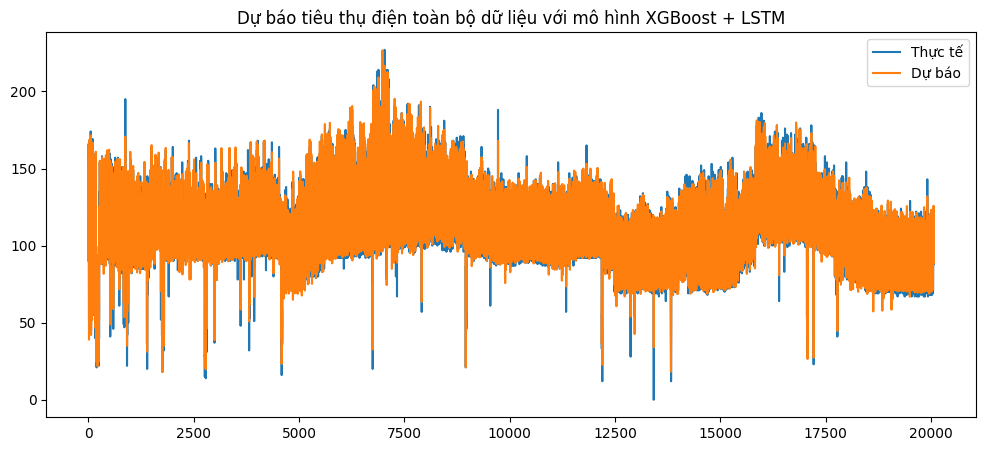

In [57]:
# ==== 9. V·∫Ω bi·ªÉu ƒë·ªì k·∫øt qu·∫£ ====
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Th·ª±c t·∫ø')
plt.plot(y_pred_inv, label='D·ª± b√°o')
plt.legend()
plt.title('D·ª± b√°o ti√™u th·ª• ƒëi·ªán to√†n b·ªô d·ªØ li·ªáu v·ªõi m√¥ h√¨nh XGBoost + LSTM')
plt.show()

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ƒê·ªô ƒëo
mae = mean_absolute_error(y_true, y_pred_inv)
mse = mean_squared_error(y_true, y_pred_inv)
rmse = np.sqrt(mse)
mask = y_true != 0
mape = np.mean(np.abs((y_true[mask] - y_pred_inv[mask]) / y_true[mask])) * 100
r2 = r2_score(y_true, y_pred_inv)

# In k·∫øt qu·∫£
print(f"üìä K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh XGBoost + LSTM tr√™n to√†n b·ªô d·ªØ li·ªáu:")
print(f"üîπ MAE  (Mean Absolute Error):       {mae:.4f}")
print(f"üîπ MSE  (Mean Squared Error):        {mse:.4f}")
print(f"üîπ RMSE (Root Mean Squared Error):   {rmse:.4f}")
print(f"üîπ MAPE (Mean Absolute % Error):     {mape:.2f}%")
print(f"üîπ R¬≤   (R-squared):                 {r2:.4f}")

üìä K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh XGBoost + LSTM tr√™n to√†n b·ªô d·ªØ li·ªáu:
üîπ MAE  (Mean Absolute Error):       3.6045
üîπ MSE  (Mean Squared Error):        22.8890
üîπ RMSE (Root Mean Squared Error):   4.7842
üîπ MAPE (Mean Absolute % Error):     3.43%
üîπ R¬≤   (R-squared):                 0.9625


In [44]:
time_index = df['date'][-len(y_true):].reset_index(drop=True)

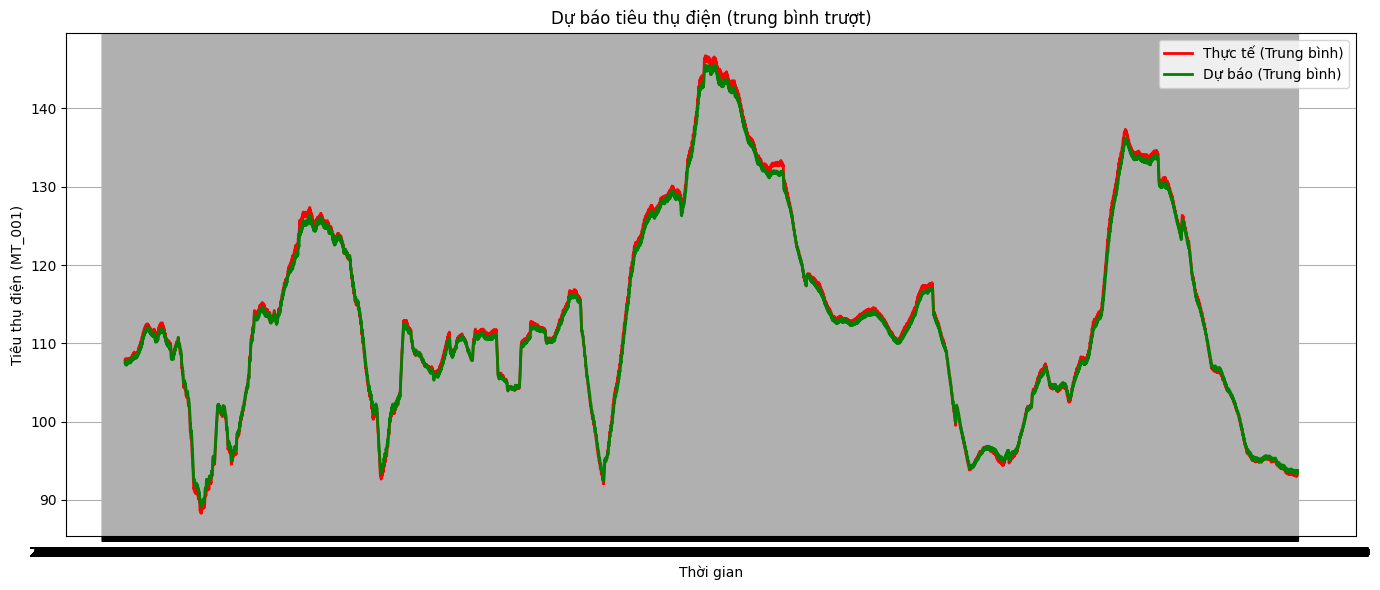

In [45]:
# ƒê·ªô d√†i c·ª≠a s·ªï tr∆∞·ª£t
window_size = 500

# T·∫°o chu·ªói trung b√¨nh tr∆∞·ª£t
y_true_ma = pd.Series(y_true.ravel()).rolling(window=window_size).mean()
y_pred_ma = pd.Series(y_pred_inv.ravel()).rolling(window=window_size).mean()


# V·∫Ω bi·ªÉu ƒë·ªì trung b√¨nh tr∆∞·ª£t
plt.figure(figsize=(14, 6))
plt.plot(time_index, y_true_ma, label='Th·ª±c t·∫ø (Trung b√¨nh)', color='red', linewidth=2)
plt.plot(time_index, y_pred_ma, label='D·ª± b√°o (Trung b√¨nh)', color='green', linewidth=2)

plt.xlabel('Th·ªùi gian')
plt.ylabel('Ti√™u th·ª• ƒëi·ªán (MT_001)')
plt.title('D·ª± b√°o ti√™u th·ª• ƒëi·ªán (trung b√¨nh tr∆∞·ª£t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

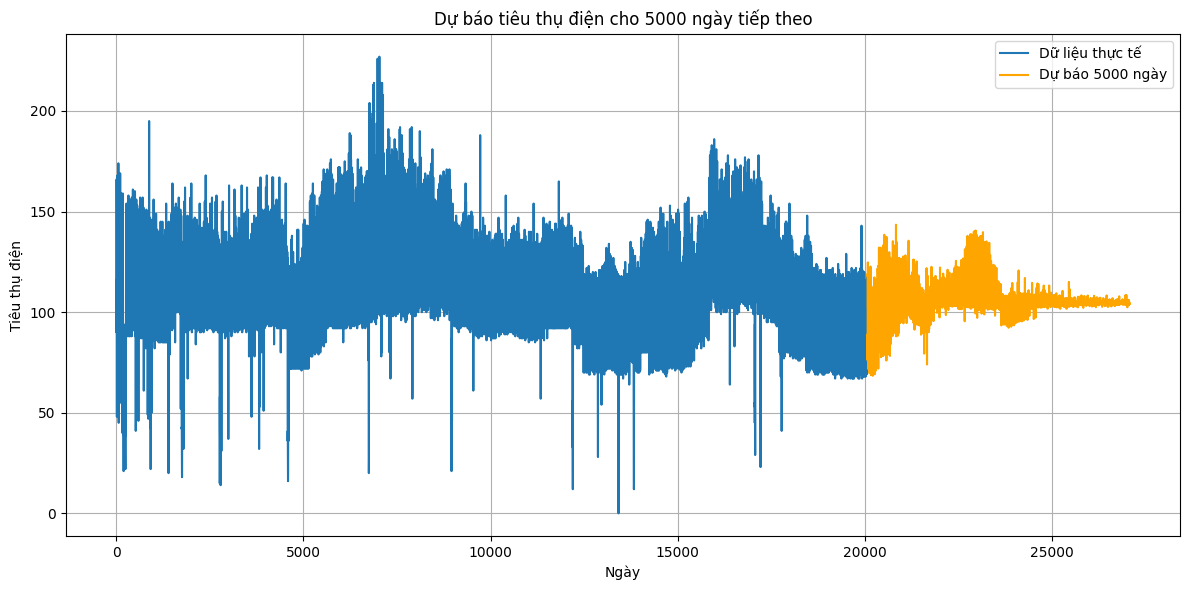

In [62]:
# ==== 10. D·ª± b√°o 500 ng√†y ti·∫øp theo ====
forecast_steps = 7000
last_seq = X_seq[-1]  # D√£y input cu·ªëi c√πng (d·∫°ng [lag, 1])
predictions = []

for _ in range(forecast_steps):
    # D·ª± b√°o v·ªõi XGBoost
    xgb_input = last_seq.reshape(1, -1)
    xgb_pred = xgb_model.predict(xgb_input).reshape(-1, 1)

    # T·∫°o input cho LSTM
    lstm_input = np.concatenate((last_seq[-1:], xgb_pred), axis=1).reshape(1, 1, 2)
    lstm_input_tensor = torch.tensor(lstm_input, dtype=torch.float32).to(device)

    # D·ª± b√°o b·∫±ng LSTM
    model.eval()
    with torch.no_grad():
        lstm_pred = model(lstm_input_tensor).cpu().numpy()

    predictions.append(lstm_pred.item())

    # C·∫≠p nh·∫≠t chu·ªói ƒë·∫ßu v√†o m·ªõi b·∫±ng c√°ch th√™m d·ª± b√°o v·ª´a r·ªìi
    new_point = np.array([[lstm_pred.item()]])
    last_seq = np.vstack((last_seq[1:], new_point))

# ==== 11. Chuy·ªÉn v·ªÅ gi√° tr·ªã g·ªëc v√† hi·ªÉn th·ªã ====
forecast_scaled = np.array(predictions).reshape(-1, 1)
forecast_original = scaler.inverse_transform(forecast_scaled)

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_true)), y_true, label='D·ªØ li·ªáu th·ª±c t·∫ø')
plt.plot(range(len(y_true), len(y_true) + forecast_steps), forecast_original, label='D·ª± b√°o 5000 ng√†y', color='orange')
plt.title('D·ª± b√°o ti√™u th·ª• ƒëi·ªán cho 5000 ng√†y ti·∫øp theo')
plt.xlabel('Ng√†y')
plt.ylabel('Ti√™u th·ª• ƒëi·ªán')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


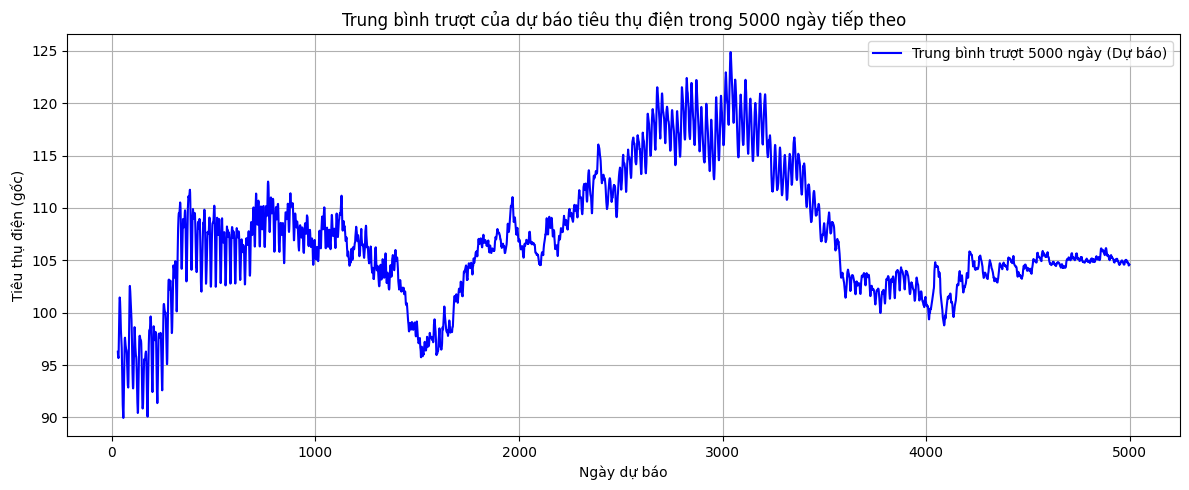

In [60]:
# ==== Trung b√¨nh tr∆∞·ª£t c·ªßa d·ªØ b√°o ====
window_size = 30  # B·∫°n c√≥ th·ªÉ thay ƒë·ªïi k√≠ch th∆∞·ªõc c·ª≠a s·ªï n·∫øu mu·ªën
forecast_ma = pd.Series(forecast_original.ravel()).rolling(window=window_size).mean()

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(12, 5))
plt.plot(forecast_ma, label=f'Trung b√¨nh tr∆∞·ª£t 5000 ng√†y (D·ª± b√°o)', color='blue')
plt.title(f'Trung b√¨nh tr∆∞·ª£t c·ªßa d·ª± b√°o ti√™u th·ª• ƒëi·ªán trong 5000 ng√†y ti·∫øp theo')
plt.xlabel('Ng√†y d·ª± b√°o')
plt.ylabel('Ti√™u th·ª• ƒëi·ªán (g·ªëc)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

forecast_horizons = [12, 24, 36, 48]
metrics = {'mae': [], 'mse': [], 'rmse': [], 'mape': [], 'r2': []}

for S in forecast_horizons:
    n_samples = 100  # Gi·ªõi h·∫°n s·ªë m·∫´u ƒë·ªÉ gi·∫£m th·ªùi gian t√≠nh to√°n
    maes, mses, rmses, mapes, r2s = [], [], [], [], []

    for i in range(n_samples):
        if i + S + 1 >= len(X_seq):
            break

        x_input = X_seq[i]
        y_target = y_seq[i+1:i+1+S].reshape(-1, 1)

        predictions = []
        last_seq = x_input.copy()

        for _ in range(S):
            xgb_input = last_seq.reshape(1, -1)
            xgb_pred = xgb_model.predict(xgb_input).reshape(-1, 1)

            lstm_input = np.concatenate((last_seq[-1:], xgb_pred), axis=1).reshape(1, 1, 2)
            lstm_input_tensor = torch.tensor(lstm_input, dtype=torch.float32).to(device)

            model.eval()
            with torch.no_grad():
                lstm_pred = model(lstm_input_tensor).cpu().numpy()

            predictions.append(lstm_pred.item())
            last_seq = np.vstack((last_seq[1:], [[lstm_pred.item()]]))

        # Chuy·ªÉn v·ªÅ d·∫°ng g·ªëc
        forecast_scaled = np.array(predictions).reshape(-1, 1)
        forecast_original = scaler.inverse_transform(forecast_scaled)
        y_true_original = scaler.inverse_transform(y_target)

        # ƒê√°nh gi√°
        mae = mean_absolute_error(y_true_original, forecast_original)
        mse = mean_squared_error(y_true_original, forecast_original)
        rmse = np.sqrt(mse)
        mask = y_true_original != 0
        mape = np.mean(np.abs((y_true_original[mask] - forecast_original[mask]) / y_true_original[mask])) * 100
        r2 = r2_score(y_true_original, forecast_original)

        maes.append(mae)
        mses.append(mse)
        rmses.append(rmse)
        mapes.append(mape)
        r2s.append(r2)

    # L∆∞u trung b√¨nh cho m·ªói S
    metrics['mae'].append(np.mean(maes))
    metrics['mse'].append(np.mean(mses))
    metrics['rmse'].append(np.mean(rmses))
    metrics['mape'].append(np.mean(mapes))
    metrics['r2'].append(np.mean(r2s))

# ==== In k·∫øt qu·∫£ trung b√¨nh to√†n b·ªô horizon ====
print("üìä Trung b√¨nh c·ªông c√°c ƒë·ªô d√†i d·ª± b√°o (S = 12, 24, 36, 48):")
print(f"üîπ MAE  (Mean Absolute Error):       {np.mean(metrics['mae']):.4f}")
print(f"üîπ MSE  (Mean Squared Error):        {np.mean(metrics['mse']):.4f}")
print(f"üîπ RMSE (Root Mean Squared Error):   {np.mean(metrics['rmse']):.4f}")
print(f"üîπ MAPE (Mean Absolute % Error):     {np.mean(metrics['mape']):.2f}%")
print(f"üîπ R¬≤   (R-squared):                 {np.mean(metrics['r2']):.4f}")


üìä Trung b√¨nh c·ªông c√°c ƒë·ªô d√†i d·ª± b√°o (S = 12, 24, 36, 48):
üîπ MAE  (Mean Absolute Error):       19.7956
üîπ MSE  (Mean Squared Error):        720.4262
üîπ RMSE (Root Mean Squared Error):   26.2894
üîπ MAPE (Mean Absolute % Error):     20.89%
üîπ R¬≤   (R-squared):                 0.3640
